In [284]:
import numpy as np
import networkx as nx

from matplotlib import pyplot as plt

---
Формат входных данных: .txt файл, каждая строка содержит информацию об одной точке -- 8 чисел, разделенные пробелами: $x, y, W, H, x\_shift_1, y\_shift_1, x\_shift_2, y\_shift_2$,

где $x, y$ -- координаты точки, $W, H$ -- размеры рамки. $x\_shift_i, y\_shift_i$ -- 2 варианта положения точки внутри рамки (отсчёт от левого нижнего угла).

---
считаем данные:

In [285]:
path = './example.txt'

points = [] 

with open(path) as file:
    for line in file.read().split('\n'):
        numbers = list(map(int, line.split(' ')))
        assert len(numbers) == 8
        
        info = {
            'name': str(len(points)),
            'x': numbers[0],
            'y': numbers[1],
            'W': numbers[2],
            'H': numbers[3],
            'x_shift_1': numbers[4],
            'y_shift_1': numbers[5],
            'x_shift_2': numbers[6],
            'y_shift_2': numbers[7],
        }
        
        points.append(info)

---
таким образом выглядят варианты рамок для вершин:

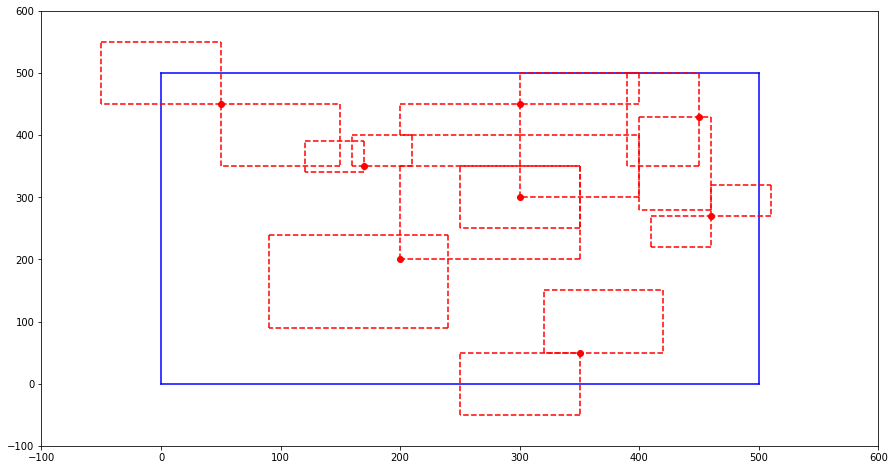

In [307]:
plt.figure(figsize=(15, 8))

# задаем пределы отрисовки
plt.ylim((-100, 600))
plt.xlim((-100, 600))

# нарисуем рамку отрисовки
plt.plot([0, 0], [0, 500], c='b')
plt.plot([0, 500], [500, 500], c='b')
plt.plot([500, 500], [500, 0], c='b')
plt.plot([500, 0], [0, 0], c='b')

for i in range(len(points)):
    plt.scatter(points[i]['x'], points[i]['y'], c='r')
    
    for  k in range(1, 3):
        box = getBoxBorders(i, k)
        plt.plot([box[0][0], box[0][0]], [box[0][1], box[1][1]], '--', c='r')
        plt.plot([box[0][0], box[1][0]], [box[1][1], box[1][1]], '--', c='r')
        plt.plot([box[1][0], box[1][0]], [box[1][1], box[0][1]], '--', c='r')
        plt.plot([box[1][0], box[0][0]], [box[0][1], box[0][1]], '--', c='r')   

plt.show()

---
построим граф всех возможных импликаций для решения задачи 2-SAT:

In [297]:
# возвращает координаты прямоугольника в формате (*, *), (*, *) --- левая нижняя и правая верхняя точки
def getBoxBorders(p_idx, shift_idx):
    x_shift = points[p_idx]['x_shift_' + str(shift_idx)]
    y_shift = points[p_idx]['y_shift_' + str(shift_idx)]

    box_x_min = points[p_idx]['x'] - x_shift
    box_y_min = points[p_idx]['y'] - y_shift
    box_x_max = box_x_min + points[p_idx]['W']
    box_y_max = box_y_min + points[p_idx]['H']
    
    return (box_x_min, box_y_min), (box_x_max, box_y_max)

def getNegName(name):
    neg_name = name
    if len(neg_name) >= 4 and neg_name[:4] == 'not_':
        neg_name = neg_name[4:]
    else:
        neg_name = 'not_' + neg_name
    return neg_name

def getName(p_idx, shift_idx):
    name = points[p_idx]['name']
    neg_name = 'not_' + points[p_idx]['name']

    if shift_idx == 2:
        name, neg_name = neg_name, name
    return name, neg_name

def intersects(box1, box2):
    overlap_x = (box1[1][0] >= box2[0][0] and box2[1][0] >= box1[0][0])
    overlap_y = (box1[1][1] >= box2[0][1] and box2[1][1] >= box1[0][1])
    return overlap_x and overlap_y

In [298]:
G = nx.DiGraph()

for i in range(len(points)):
    G.add_node(points[i]['name'])
    G.add_node('not_' + points[i]['name'])
    
for i in range(len(points)):
    for j in range(i + 1, len(points)):
        for k1 in range(1, 3):
            for k2 in range(1, 3):
            
                p1_name, p1_neg_name = getName(i, k1)
                p2_name, p2_neg_name = getName(j, k2)

                box1 = getBoxBorders(i, k1)
                box2 = getBoxBorders(j, k2)

                if (intersects(box1, box2)):
                    G.add_edge(p1_name, p2_neg_name)
                    G.add_edge(p2_name, p1_neg_name)

---
Проверим на выполнимость:

In [299]:
G_rev = G.reverse()

def mark(ver):
    if ver in values.keys():
        if values[ver] == False:
            values['ok'] = False
        return
    neg_ver = getNegName(ver)
    values[ver] = True
    values[neg_ver] = False
    
    for v in G.neighbors(ver):
        mark(v)
    for v in G_rev.neighbors(neg_ver):
        mark(getNegName(v))

In [300]:
values = {}
values['ok'] = True

# Проверим, что для переменные x_i, и not_x_i лежат в разных компонентах
comp_cnt = 0
comps = {}

for c in nx.strongly_connected_components(G):
    vs = []
    for v in c:
        vs.append(getNegName(v) if len(v) >= 4 else v)
        comps[v] = comp_cnt
    
    if len(c) != len(set(vs)):
        ok = False
    comp_cnt += 1
        
# обработаем прямоугольники, выходящие за пределы отрисовки
for i in range(len(points)):
    good = []
    for k in range(1, 3):
        box = getBoxBorders(i, k)
        flag = (min(list(box[0]) + list(box[1])) >= 0 and max(list(box[0]) + list(box[1])) <= 500)
        good.append(flag)
    
    if not good[0] and not good[1]:
        values['ok'] = False
        break
    if not good[0] and good[1]:
        mark('not_' + points[i]['name'])
    
    if good[0] and not good[1]:
        mark(points[i]['name'])

In [301]:
values

{'ok': True,
 'not_0': True,
 '0': False,
 'not_1': True,
 '1': False,
 'not_2': True,
 '2': False,
 'not_3': True,
 '3': False,
 'not_4': True,
 '4': False,
 'not_5': True,
 '5': False,
 'not_6': True,
 '6': False,
 'not_7': True,
 '7': False}

---
Расставим метки вершинам в соответствии с топологической сортировкой компонент сильной связности:

In [302]:
ts = nx.DiGraph()
ts.add_nodes_from(np.arange(0, comp_cnt))

for e in G.edges:
    if comps[e[0]] == comps[e[1]]:
        continue
    if not ts.has_edge(comps[e[0]], comps[e[1]]):
        ts.add_edge(comps[e[0]], comps[e[1]])

ts_comp = {}

for i, idx in enumerate(list(nx.topological_sort(ts))):
    ts_comp[idx] = i

---
Обработаем вершины и расставим метки:

In [303]:
for i in range(len(points)):
    name = points[i]['name']
    neg_name = getNegName(name)
    if not name in values.keys():
        if ts_comp[comps[name]] > ts_comp[comps[neg_name]]:
            mark(name)
        else:
            mark(neg_name)

---
проверим, существует ли решение у задачи:

In [304]:
if values['ok']:
    print('The solution exists!!!')
else:
    print('The solution doesn\'t exists :(')

The solution exists!!!


---
приступим к отрисовке:

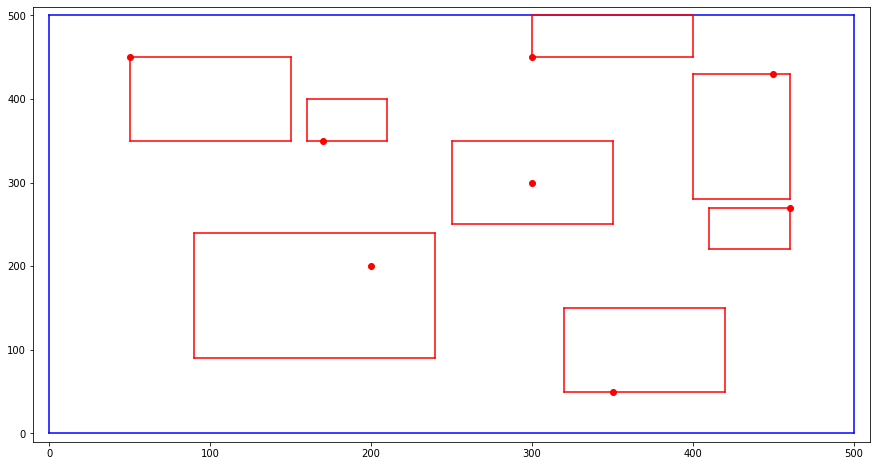

In [308]:
plt.figure(figsize=(15, 8))

# задаем пределы отрисовки
plt.ylim((-10, 510))
plt.xlim((-10, 510))

# нарисуем рамку отрисовки
plt.plot([0, 0], [0, 500], c='b')
plt.plot([0, 500], [500, 500], c='b')
plt.plot([500, 500], [500, 0], c='b')
plt.plot([500, 0], [0, 0], c='b')

for i in range(len(points)):
    plt.scatter(points[i]['x'], points[i]['y'], c='r')
    
    box = getBoxBorders(i, 1)
    if not values[points[i]['name']]:
        box = getBoxBorders(i, 2)
    
    plt.plot([box[0][0], box[0][0]], [box[0][1], box[1][1]], c='r')
    plt.plot([box[0][0], box[1][0]], [box[1][1], box[1][1]], c='r')
    plt.plot([box[1][0], box[1][0]], [box[1][1], box[0][1]], c='r')
    plt.plot([box[1][0], box[0][0]], [box[0][1], box[0][1]], c='r')
    

plt.savefig('result.png', format='png')
plt.show()